In [1]:
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

from scipy.stats import pearsonr, spearmanr

In [2]:
def interval_transform(x, a, b):
    m = x.min()
    ma = x.max()
    
    alpha_inv = (1 - m/ma)*ma/(a - b)
    alpha = 1/alpha_inv
    beta = b - alpha*m
    
    f = lambda x: alpha*x + beta 
    return f(x)

def make_noise_feature(x):
    n_features = x.shape[1]
    n_samples = x.shape[0]
    
    weights = np.random.uniform(1e-4, 1e-2, n_features)
    noise = np.random.normal(1, 5, n_samples)
    signal = np.sum(weights*x, -1) 
    return signal + noise

def calculate_pvalues(df,
                      method = spearmanr
                     ):
    """
    Assumes df with only numeric entries clean of null entries. 
    """
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(method(df[r], df[c])[1], 4)
    return pvalues

def correlation_matrix(df,
                       method = "pearson",
                       annot_bool = False,
                       annot_size = 20
                      ):
    # Compute the correlation matrix
    corr = df.corr(method = method)

    if annot_bool:
        annot = corr.copy()
        
        if method == "pearson":
            sig_meth = pearsonr
        else:
            sig_meth = spearmanr
            
        pval = calculate_pvalues(df, sig_meth) 
        # create three masks
        r0 = corr.applymap(lambda x: '{:.2f}'.format(x))
        r1 = corr.applymap(lambda x: '{:.2f}*'.format(x))
        r2 = corr.applymap(lambda x: '{:.2f}**'.format(x))
        r3 = corr.applymap(lambda x: '{:.2f}***'.format(x))
  
        # apply them where appropriate --this could be a single liner
        annot = annot.where(pval>0.1,r0)
        annot = annot.where(pval<=0.1,r1)
        annot = annot.where(pval<=0.05,r2)
        annot = annot.mask(pval<=0.01,r3)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 11))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot = annot,
                fmt = "",
                annot_kws={"size": annot_size},
                vmin = -1,
                vmax = 1,
               )

In [3]:
n_info = 3
n_redu = 0
n_samples=2000

#making nonlinear decision boundaries requires multiple blob like features 
X1, y1 = make_blobs(
        n_samples=n_samples,
        n_features=2,
        centers=np.array([[42, 39], [39.5, 38.3]]),
        shuffle=False,
        random_state=42, 
        #difficulty,
        cluster_std=1.4,
        )

X2, y2 = make_blobs(
        n_samples=n_samples,
        n_features=2,
        centers=np.array([[44, 39.8], [38, 37.9]]),
        cluster_std=1.2,
        shuffle=False,
        random_state=6, 
        #difficulty,
    
        )

X3, y3 = make_moons(n_samples=2*n_samples, noise=1, random_state=42)

X = np.concatenate([X1, X2], axis=0)
y = np.concatenate([y1, y2], axis=0)

data = np.concatenate([X, np.expand_dims(y, -1)], -1)
data = pd.DataFrame(data)

In [4]:
print(X.shape)

(4000, 2)


In [5]:
data.head()

,0,1,2
0,42.695400,38.806430,0.0
1,42.906764,41.132242,0.0
2,41.672185,38.672208,0.0
3,44.210898,40.074409,0.0
4,41.342736,39.759584,0.0


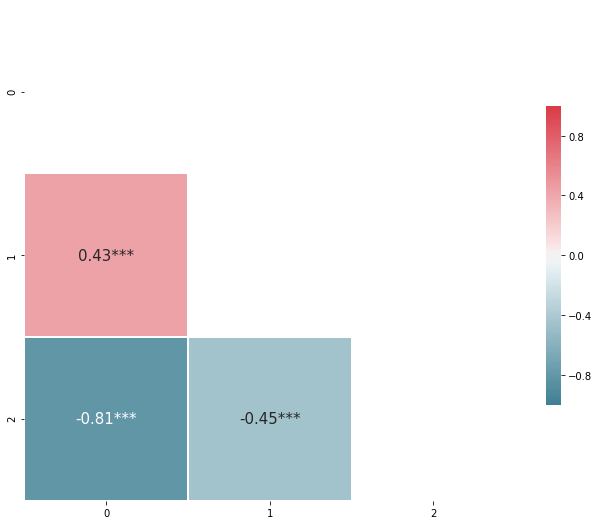

In [6]:
correlation_matrix(data, annot_bool=True, annot_size=15)

(array([2000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

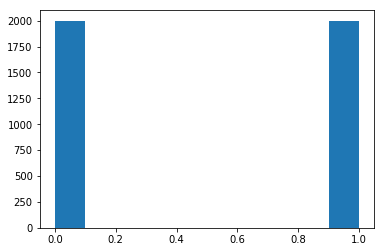

In [7]:
plt.hist(y)

To educationify the data we scale and transform the dataset:

For the informative features we'll use:
* GPA [0, 4] unit:grade
* Attendance [0, 100] unit:percent
* Passed percent of classes [0, 100] unit:percent

For the redundant we'll use: 
* Sex [0, 1] unit:integer class
* Ethnicity [0, 1, 2] unit:integer class
* HSGPA [0, 4] unit:grade


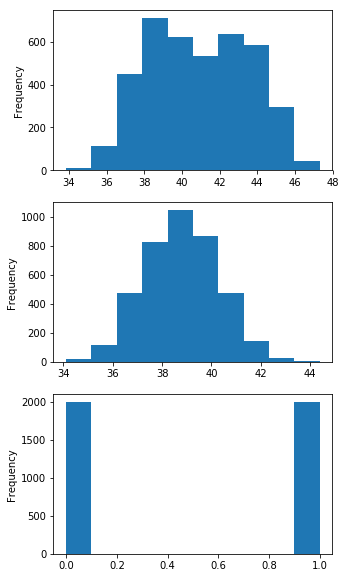

In [8]:
fig, axs = plt.subplots(nrows=n_info, figsize=(5, 10 ))
for i in range(n_info):
    ax = axs[i]
    data[i].plot(kind="hist", ax=ax)

(array([ 44., 295., 584., 636., 535., 624., 712., 450., 112.,   8.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

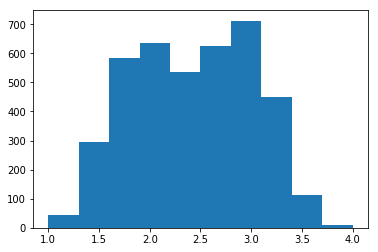

In [9]:
gpa_column = interval_transform(data[0], 1, 4) 
plt.hist(gpa_column)

(array([   5.,   24.,  147.,  472.,  866., 1050.,  824.,  477.,  115.,
          20.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

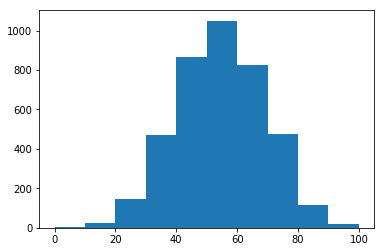

In [10]:
passed_column = interval_transform(data[1], 0, 100)
plt.hist(passed_column)

In [11]:
gpa_column.shape

(4000,)

In [12]:
full_data = np.concatenate(
                [
                    np.expand_dims(gpa_column, axis=-1),
                    np.expand_dims(passed_column, axis=-1),
                    np.expand_dims(y, axis=-1)
                ],
                axis=1
)

columns = [              
            "cGPA",
            "passed_percent",
            "degree",
        ]

df_full = pd.DataFrame(full_data,
                       columns=columns)

In [13]:
df_full.head()

,cGPA,passed_percent,degree
0,2.029622,54.344605,0.0
1,1.982509,31.723089,0.0
2,2.257693,55.650084,0.0
3,1.691822,42.011880,0.0
4,2.331126,45.073954,0.0


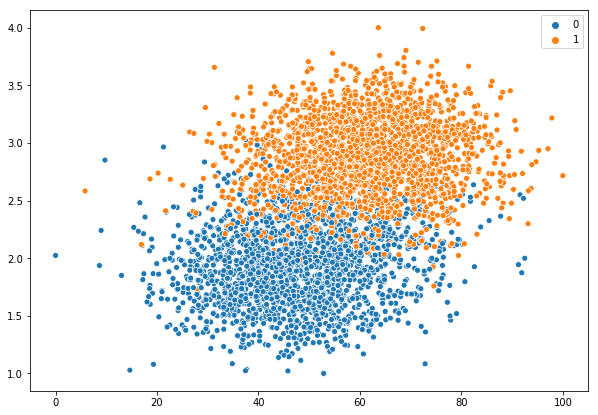

In [14]:
comb = [(1, 0),]
fig, axs = plt.subplots(nrows=len(comb), figsize=(10, 7))

for i in range(len(comb)):
    sns.scatterplot(full_data[:,comb[i][0]], full_data[:,comb[i][1]], hue=y, ax=axs)

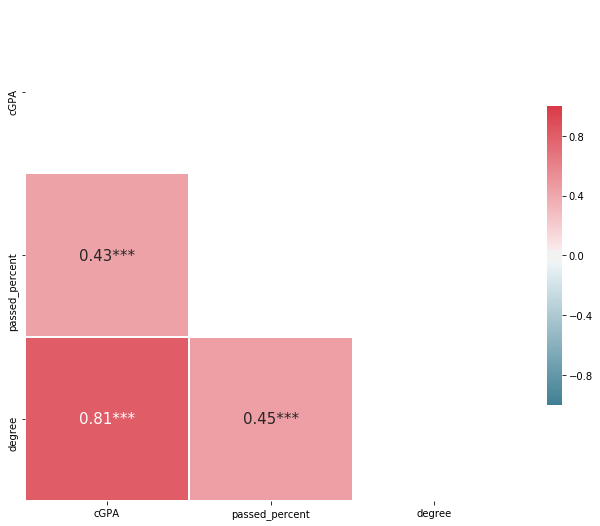

In [15]:
correlation_matrix(df_full, annot_bool=True, annot_size=15)

In [16]:
t_X = X.copy()
fd = full_data[:, :-1].copy()

for i in range(t_X.shape[1]):
    t_X[:,i] = (t_X[:,i] - t_X[:,i].mean())/t_X[:,i].std()
    
for i in [0, 1, -1]:
    fd[:,i] = (fd[:,i] - fd[:,i].mean())/fd[:,i].std()


#x_train, x_test, y_train, y_test = train_test_split(t_X, y, shuffle=True)
x_train, x_test, y_train, y_test = train_test_split(fd, full_data[:,-1], shuffle=True)

In [17]:
model = KMeans(n_clusters=2)
model.fit(fd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [18]:

def kmeans_plot(df,labels,centers):
    
    x_min, x_max = df[:, 1].min() - 1, df[:, 1].max() + 1
    y_min, y_max = df[:, 0].min() - 1, df[:, 0].max() + 1
    
    plt.scatter(df[:, 1], df[:, 0], c=labels, cmap = 'viridis')
    plt.scatter(centers[:, 1], centers[:, 0], marker='x', c = 'k')
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    title = "KMeans Clustering of an education-like dataset with "+str(len(centers))+" clusters"
    plt.title(title)
    plt.show()

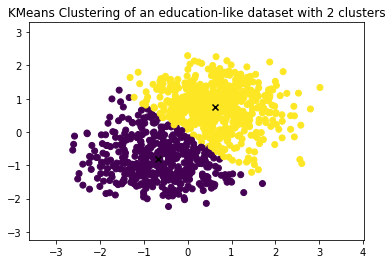

In [19]:
kmeans_plot(x_test, model.predict(x_test), model.cluster_centers_)

In [20]:
print("KM model",
      adjusted_rand_score(y_test, model.predict(x_test)), 
      adjusted_mutual_info_score(y_test, model.predict(x_test)))

KM model 0.5771758398407759 0.4735022037645568


/usr/local/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [21]:
pd.to_pickle(df_full, "clustering_data.pkl")